In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [3]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
from scipy.optimize import fmin_l_bfgs_b

In [5]:
import tensorflow as tf
if tf.__version__.startswith('2'):
  tf.compat.v1.disable_eager_execution()

In [6]:
def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  # new_model = Sequential()
  # for layer in vgg.layers:
  #   if layer.__class__ == MaxPooling2D:
  #     # replace it with average pooling
  #     new_model.add(AveragePooling2D())
  #   else:
  #     new_model.add(layer)

  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      x = AveragePooling2D()(x)
    else:
      x = layer(x)

  return Model(i, x)

In [7]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  # new_model = Sequential()
  # n = 0
  # for layer in model.layers:
  #   if layer.__class__ == Conv2D:
  #     n += 1
  #   new_model.add(layer)
  #   if n >= num_convs:
  #     break

  n = 0
  output = None
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break

  return Model(model.input, output)

In [8]:
def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img


def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2:0
iter=0, loss=888.894287109375
iter=1, loss=449.6595764160156
iter=2, loss=295.0044860839844
iter=3, loss=222.9308319091797
iter=4, loss=181.14744567871094
iter=5, loss=154.64759826660156
iter=6, loss=136.0462646484375
iter=7, loss=121.89581298828125
iter=8, loss=110.6985855102539
iter=9, loss=101.94388580322266
iter=10, loss=94.57756042480469
iter=11, loss=88.56819152832031
iter=12, loss=83.33265686035156
iter=13, loss=78.90036010742188
iter=14, loss=74.87151336669922
iter=15, loss=71.09391021728516
iter=16, loss=68.02043914794922
iter=17, loss=65.33517456054688
iter=18, loss=62.88618469238281
iter=19, loss=60.65630340576172
duration: 0:01:49.706731


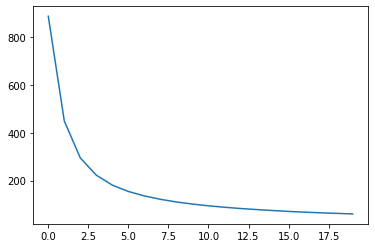

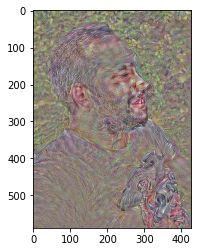

In [15]:
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
  config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
    
    
    # open an image
  # feel free to try your own
  # path = '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg'
  path = 'C:/Users/eugur/Jupyter/Advanced_Deep_Learning/Github/machine_learning_examples/cnn_class2/content/enes.JPG'
  img = image.load_img(path)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  # we'll use this throughout the rest of the script
  batch_shape = x.shape
  shape = x.shape[1:]

  # see the image
  # plt.imshow(img)
  # plt.show()


  # make a content model
  # try different cutoffs to see the images that result
  content_model = VGG16_AvgPool_CutOff(shape, 11)

  # make the target
  target = K.variable(content_model.predict(x))


  # try to match the image

  # define our loss in keras
  loss = K.mean(K.square(target - content_model.output))

  # gradients which are needed by the optimizer
  grads = K.gradients(loss, content_model.input)

  # just like theano.function
  get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
  )


  def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)



  from datetime import datetime
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(20):
    x, l, _ = fmin_l_bfgs_b(
      func=get_loss_and_grads_wrapper,
      x0=x,
      # bounds=[[-127, 127]]*len(x.flatten()),
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)


  plt.imshow(scale_img(final_img[0]))
  plt.show()


In [16]:
def gram_matrix(img):
  # input is (H, W, C) (C = # feature maps)
  # we first need to convert it to (C, H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
  
  # now, calculate the gram matrix
  # gram = XX^T / N
  # the constant is not important since we'll be weighting these
  G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
  return G


def style_loss(y, t):
  return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))


# let's generalize this and put it into a function
def minimize(fn, epochs, batch_shape):
  t0 = datetime.now()
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
      func=fn,
      x0=x,
      maxfun=20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i, l))
    losses.append(l)

  print("duration:", datetime.now() - t0)
  plt.plot(losses)
  plt.show()

  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_3:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_3:0
iter=0, loss=9587.9677734375
iter=1, loss=327.0505065917969
iter=2, loss=144.4908905029297
iter=3, loss=96.9196548461914
iter=4, loss=67.69396209716797
iter=5, loss=50.585758209228516
iter=6, loss=37.57265090942383
iter=7, loss=28.2774715423584
iter=8, loss=21.70982551574707
iter=9, loss=17.805017471313477
duration: 0:00:42.499254


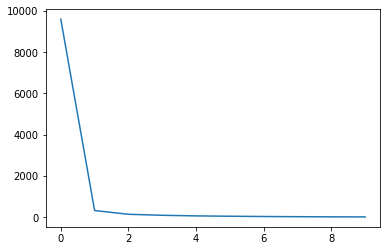

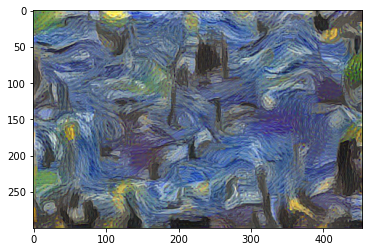

In [17]:
path = 'C:/Users/eugur/Jupyter/Advanced_Deep_Learning/Github/machine_learning_examples/cnn_class2/styles/starrynight.jpg'
# load the data
img = image.load_img(path)

# convert image to array and preprocess for vgg
x = image.img_to_array(img)

# look at the image
# plt.imshow(x)
# plt.show()

# make it (1, H, W, C)
x = np.expand_dims(x, axis=0)

# preprocess into VGG expected format
x = preprocess_input(x)

# we'll use this throughout the rest of the script
batch_shape = x.shape
shape = x.shape[1:]

# let's take the first convolution at each block of convolutions
# to be our target outputs
# remember that you can print out the model summary if you want
vgg = VGG16_AvgPool(shape)

# Note: need to select output at index 1, since outputs at
# index 0 correspond to the original vgg with maxpool
symbolic_conv_outputs = [
layer.get_output_at(1) for layer in vgg.layers \
if layer.name.endswith('conv1')
]

# pick the earlier layers for
# a more "localized" representation
# this is opposed to the content model
# where the later layers represent a more "global" structure
# symbolic_conv_outputs = symbolic_conv_outputs[:2]

# make a big model that outputs multiple layers' outputs
multi_output_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in multi_output_model.predict(x)]

# calculate the total style loss
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
# gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])

grads = K.gradients(loss, multi_output_model.input)

# just like theano.function
get_loss_and_grads = K.function(
inputs=[multi_output_model.input],
outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()

In [18]:
# load the content image
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

content_img = load_img_and_preprocess(
  # '../large_files/caltech101/101_ObjectCategories/elephant/image_0002.jpg',
  # 'batman.jpg',
  'C:/Users/eugur/Jupyter/Advanced_Deep_Learning/Github/machine_learning_examples/cnn_class2/content/dilara2.JPG',
  # (225, 300),
)

# resize the style image
# since we don't care too much about warping it
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(
  # 'styles/starrynight.jpg',
  # 'styles/flowercarrier.jpg',
  # 'styles/monalisa.jpg',
  'C:/Users/eugur/Jupyter/Advanced_Deep_Learning/Github/machine_learning_examples/cnn_class2/styles/flowercarrier.jpg',
  (h, w)
)


# we'll use this throughout the rest of the script
batch_shape = content_img.shape
shape = content_img.shape[1:]


# we want to make only 1 VGG here
# as you'll see later, the final model needs
# to have a common input
vgg = VGG16_AvgPool(shape)


# create the content model
# we only want 1 output
# remember you can call vgg.summary() to see a list of layers
# 1,2,4,5,7-9,11-13,15-17
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))


# create the style model
# we want multiple outputs
# we will take the same approach as in style_transfer2.py
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses
style_weights = [5,5,5,5,5]



# create the total loss which is the sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0])


# once again, create the gradients and loss + grads function
# note: it doesn't matter which model's input you use
# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

# just like theano.function
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)


def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()
img = cv2.cvtColor(final_img.astype('float32'),cv2.COLOR_RGB2BGR)
cv2.imwrite('final_img4.jpg',img)


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_12:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_12:0


C:\Users\eugur\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:2371: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_12:0
iter=0, loss=54109.17578125
iter=1, loss=13661.599609375
iter=2, loss=7391.44970703125
iter=3, loss=5068.46142578125
iter=4, loss=3924.854736328125
iter=5, loss=3184.7138671875
iter=6, loss=2708.16162109375
iter=7, loss=2397.21533203125


In [51]:
img = cv2.cvtColor(final_img.astype('float32'),cv2.COLOR_RGB2BGR)
cv2.imwrite('final_img.jpg',img)

True